In [1]:
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
import numpy as np

In [2]:
mpc2m = 3.086e22
pc2cm = 3.086e18

In [3]:
def calc_alpha0(L):
    
    """
    Spectral index at 60um at z=0
    Ref: http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1987ApJ...316L..15H&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
    """
    
    if (L<1e22):
        alpha0 = 2.7
    elif (L>1e22) and (L<10**(25.4)):
        alpha0 = 2.7 - 0.5*np.log10(L/1e22)
    elif (L>10**(25.4)):
        alpha0 = 1.0
    
    return alpha0

In [4]:
def alpha_60(L,z):
    
    """
    Spectral index at 60um
    Ref: http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1987ApJ...316L..15H&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
    """
    
    alpha_25 = 2.4
    alpha_0 = calc_alpha0(L)
    
    if (z>0.41):
        alpha = alpha_25
    elif (z<=0.41):
        alpha = alpha_25*( np.log10(1+z)/np.log10(1.41) ) + alpha_0*( np.log10((1+z)/1.41) / np.log(1.41) )
    
    return alpha

In [5]:
def rho_0(L):
    
    """
    Eq. 13 & 14 from PB96: https://arxiv.org/pdf/astro-ph/9605119.pdf
    """
    
    b = 1.51
    w = 0.85
    x = 23.96
    y = 5.93
    
    q = y - ( b**2 + ((np.log10(L) - x)/w)**2 )**0.5 - 2.5*np.log10(L)
    
    rho0 = 2.94e28*10**q  # Mpc^-3 (Watts Hz^-1)^-1
    rho0/= (mpc2m)**3
    
    return rho0

In [6]:
def calc_L60_integrand(L60,z):
    
    """
    Integrand for nested integral from Eq. 16 of PB96: https://arxiv.org/pdf/astro-ph/9605119.pdf
    Uses fitted luminosity evolution from Eq. 22 of PB96: https://arxiv.org/pdf/astro-ph/9605119.pdf
    """
    
    g_z = 1.
    
    z0 = 0.8
    if (z<z0):
        f_z = (1+z)**4
    elif (z>=z0):
        f_z = (1+z0)**4

    # Equation 15 PB96:
    Ldash = L60/f_z
    rho_60_z = (g_z/f_z)*rho_0(Ldash)
    
    # ratio of L_1.4GHz to L_60um
    # Eq 3 PB96:
    alpha = alpha_60(L60,z)
    lum_ratio = 1.69e-3*(2.58+1.67**alpha)
    
    integrand = rho_60_z*lum_ratio*L60
    
    return integrand

In [7]:
def calc_z_integrand(z):
    
    """
    Integrand for Eq. 16 of PB96: https://arxiv.org/pdf/astro-ph/9605119.pdf
    
    """
    
    # dVc/dz calculated following: https://ned.ipac.caltech.edu/level5/Hogg/Hogg9.html
    # output in units of Mpc^3 sr^-1 (note d\Omega in definition - sr probably normally
    # neglected as dimensionless unit)
    dVc_dz = cosmo.hubble_distance*(1+z)**2*cosmo.angular_diameter_distance(z)**2/cosmo.efunc(z)
    dVc_dz_m3 = dVc_dz.value*mpc2m**3
    
    Dlum = cosmo.luminosity_distance(z)
    
    L60_min = 1e10; L60_max = 1e28
    integral_L60 = quad(calc_L60_integrand,L60_min,L60_max,args=(z))[0]
    
    integrand = integral_L60*dVc_dz_m3*(1+z)/(4.*np.pi*Dlum.value**2*mpc2m**2)
    
    return integrand

In [8]:
def calc_Inu():
    
    """
    Eq. 16 from PB96: https://arxiv.org/pdf/astro-ph/9605119.pdf
    
    Change: removed factor 1/4\pi because dVc/dz already in units of m^3 sr^-1
    
    """
    zmin = 0.;zmax = 10.
    integral_z = quad(calc_z_integrand,zmin,zmax)[0]
    
    #I_nu = (1./(4.*np.pi))*integral_z
    I_nu = integral_z
    
    return I_nu

In [9]:
I_21cm = calc_Inu()

print I_21cm

4.91399356873e-23


---

This next bit is just re-calculating $L_{\nu}/L_{\rm 1.4}$ from Fig 1(a) to go into Eq. 16:



In [10]:
import pylab as pl

from pacholcsyk import *
from freefree import *

In [11]:
gal_radius_kpc = 15.
gal_height_kpc = 2.
H_G = 6e-6				# [G] = 6 uGauss  [CGS units]
ne_cm = 0.01			# cm^-3	[CGS units]
Te = 3e5				# [K]
N0 = 1e-8				# what should this be..? [m^-3 MeV^-1]

In [12]:
nu = 10**np.arange(3,10,0.1)  # 1 kHz -> 10 GHz

In [13]:
em_nu = calc_em_synch(nu,H_G,N0)

integrals.py:15: RuntimeWarning: divide by zero encountered in log
  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)


In [14]:
kappa_nu = kappa_ff(nu,ne_cm,Te)  # pc^-1
kappa_nu/= pc2cm

In [15]:
dl = gal_radius_kpc*1000.*pc2cm
tau_nu = kappa_nu*dl # dimensionless

In [16]:
em_nu = (em_nu/kappa_nu)*(1 - np.exp(-1.*tau_nu))

In [17]:
nu_21cm = np.array([1.4e9])
em_21cm = calc_em_synch(nu_21cm,H_G,N0)
kappa_21cm = kappa_ff(nu_21cm,ne_cm,Te)  # pc^-1
kappa_21cm/= pc2cm
tau_21cm = kappa_21cm*dl # dimensionless
em_21cm=(em_21cm/kappa_21cm)*(1 - np.exp(-1.*tau_21cm))

In [18]:
i_nu = em_nu/em_21cm

Now we've calculated it, we can make the spectrum from Fig 5(b):

In [19]:
i_nu*= I_21cm

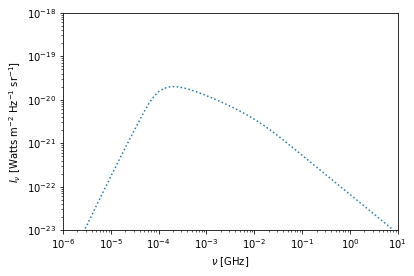

In [20]:
pl.subplot(111)
pl.plot(nu/1e9,i_nu,ls=":")
pl.axis([10**-6,10,10**(-23),10**(-18)])
pl.xlabel(r"$\nu$ [GHz]")
pl.ylabel(r"$I_{\nu}$ [Watts m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]")
pl.loglog()
pl.show()

This is shifted slightly to higher frequency compared to PB96 Fig 5(b) - I think that's due to the choice of viewing angle in calculating the free-free absorption in the spectrum